# **Stage Four - CNN Model**

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import scipy.ndimage
import IPython.display as ipd

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
# from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Model
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle



In [2]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-4/train_features_4s.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-4/val_features_4s.pkl'

csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-4-trainval-2.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [3]:
with open(train_pkl_path, 'rb') as f:
    train_features = pickle.load(f)

In [4]:
with open(val_pkl_path, 'rb') as f:
    val_features  = pickle.load(f)

# Have to encode the labels:

In [5]:
# Extract all labels from training and validation sets
all_labels = list(train_features.values()) + list(val_features.values())
all_labels = [label for (_, label) in all_labels]

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [7]:
# Transform the labels in the training and vaidation dataset
def encode_labels(feature_dict, label_encoder):
    encoded_dict = {}
    for key, (features, label) in feature_dict.items():
        encoded_label = label_encoder.transform([label])[0]
        encoded_dict[key] = (features, encoded_label)
    return encoded_dict

In [8]:
# Apply the encoding to train and validation datasets
train_features_encoded = encode_labels(train_features, label_encoder)
val_features_encoded = encode_labels(val_features, label_encoder)

In [9]:
# Check the mapping of labels
print(f"Classes: {label_encoder.classes_}")
print(f"Example encoded label: {train_features_encoded["blakit1/XC180975.npy_window_2"][1]}")

Classes: ['blakit1' 'blbpuf2' 'carcha1' 'categr' 'colsun2' 'combul2' 'egygoo'
 'fotdro5' 'gargan' 'gnbcam2' 'grecor' 'greegr' 'litegr' 'ratcis1'
 'rbsrob1' 'rerswa1' 'somgre1' 'tafpri1' 'wbrcha2' 'yertin1']
Example encoded label: 0


In [10]:
def prepare_data_for_cnn(feature_dict, num_classes):
    X = []
    y = []
    
    for key, (features, label) in feature_dict.items():
        # Concatenate the Mel spectrogram, RMS, Chroma, and MFCC features
        stacked_features = np.stack([
            features["mel_spectrogram"],
            features["rms_energy"],
            features["chroma"],
            features["mfcc"]
        ], axis=-1)
        
        X.append(stacked_features)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    # One-hot encode the labels
    y = to_categorical(y, num_classes)
    
    return X, y

In [11]:
num_classes = len(label_encoder.classes_)
num_classes

20

### Preparing Training Data

In [12]:
train_X, train_y = prepare_data_for_cnn(train_features_encoded, num_classes)

### Preparing Validation Data

In [13]:
val_X, val_y = prepare_data_for_cnn(val_features_encoded, num_classes)

In [14]:
print(f"Training data shape: {train_X.shape}, Labels shape: {train_y.shape}")
print(f"Validation data shape: {val_X.shape}, Labels shape: {val_y.shape}")

Training data shape: (33203, 128, 128, 4), Labels shape: (33203, 20)
Validation data shape: (13844, 128, 128, 4), Labels shape: (13844, 20)


# Building CNN Model

In [26]:
def cnn_model_one(input_shape=(128, 128, 4), num_classes=20):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Fully Connected Layers with Dropout
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [30]:
def cnn_model_two(input_shape=(128, 128, 4), num_classes=20):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Fully Connected Layers with Dropout
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # if the validation loss does not improve for 3 epochs, the training will stop.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001) # reduce the learning rate by a factor of 0.5 if the validation loss does not improve for 3 epochs, with a minimum learning rate of 0.00001

In [18]:
def cnn_model_three(input_shape=(128, 128, 4), num_classes=20):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Fully Connected Layers with Dropout
    model.add(layers.Dense(256, activation='relu')) # Added regularization and reduced model complexity
    model.add(layers.Dropout(0.4))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Training Model

In [27]:
model_1 = cnn_model_one()
history_1 = model_1.fit(train_X, train_y, 
                    epochs=5, 
                    batch_size=32, 
                    validation_data=(val_X, val_y))

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 335s 320ms/step - accuracy: 0.2851 - loss: 7.0700 - val_accuracy: 0.3944 - val_loss: 2.0961
Epoch 2/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 332s 320ms/step - accuracy: 0.5496 - loss: 1.5051 - val_accuracy: 0.4372 - val_loss: 2.0251
Epoch 3/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 315s 304ms/step - accuracy: 0.6437 - loss: 1.1699 - val_accuracy: 0.4380 - val_loss: 2.1849
Epoch 4/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 316s 305ms/step - accuracy: 0.7020 - loss: 0.9472 - val_accuracy: 0.4494 - val_loss: 2.2931
Epoch 5/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 314s 303ms/step - accuracy: 0.7594 - loss: 0.7555 - val_accuracy: 0.4601 - val_loss: 2.4066


In [28]:
# Evaluate model on validation set
val_loss, val_accuracy = model_1.evaluate(val_X, val_y)
print(f"Validation Accuracy: {val_accuracy}")

433/433 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5092 - loss: 2.1551
Validation Accuracy: 0.4600549042224884


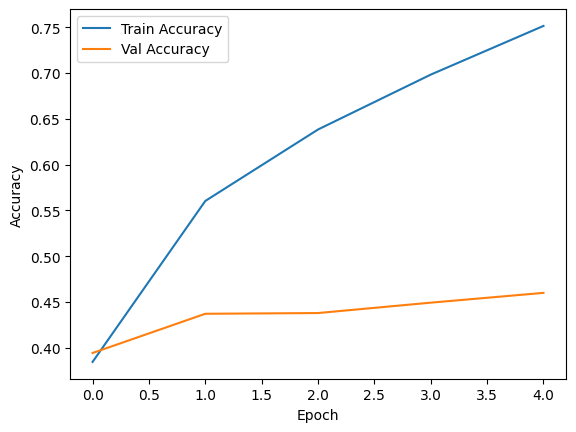

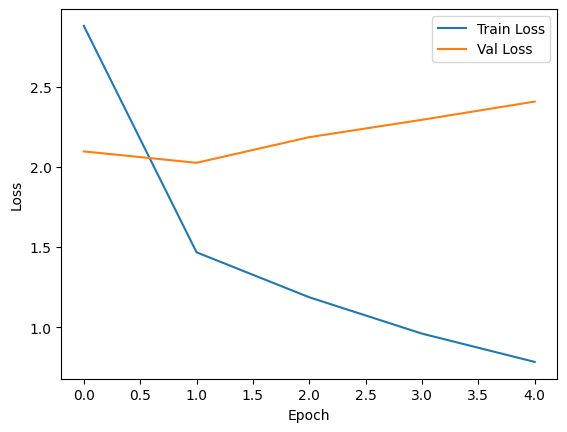

In [29]:
# Plot accuracy
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
model_2 = cnn_model_two()
history_2 = model_2.fit(train_X, train_y, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(val_X, val_y))


c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 314s 300ms/step - accuracy: 0.3223 - loss: 3.4477 - val_accuracy: 0.4359 - val_loss: 1.9709
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 303s 292ms/step - accuracy: 0.6031 - loss: 1.3021 - val_accuracy: 0.4581 - val_loss: 1.9748
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 309s 298ms/step - accuracy: 0.7029 - loss: 0.9733 - val_accuracy: 0.4752 - val_loss: 2.0911
Epoch 4/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 305s 294ms/step - accuracy: 0.7656 - loss: 0.7481 - val_accuracy: 0.4850 - val_loss: 2.3351
Epoch 5/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 300s 289ms/step - accuracy: 0.8215 - loss: 0.5599 - val_accuracy: 0.4659 - val_loss: 2.6122
Epoch 6/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 298s 287ms/step - accuracy: 0.8562 - loss: 0.4551 - val_accuracy: 0.4734 - val_loss: 2.7860
Epoch 7/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 297s 287ms/step - accuracy: 0.8805 - loss: 0.3715 - val_accuracy: 0.4770 - val_loss: 3.1621
Epoch 8/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 300s 289ms/step - ac

In [32]:
# Evaluate model on validation set
val_loss, val_accuracy = model_2.evaluate(val_X, val_y)
print(f"Validation Accuracy: {val_accuracy}")


433/433 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.5348 - loss: 3.4298
Validation Accuracy: 0.47681304812431335


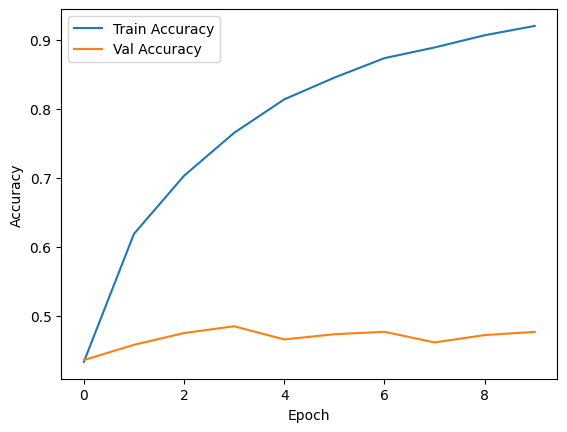

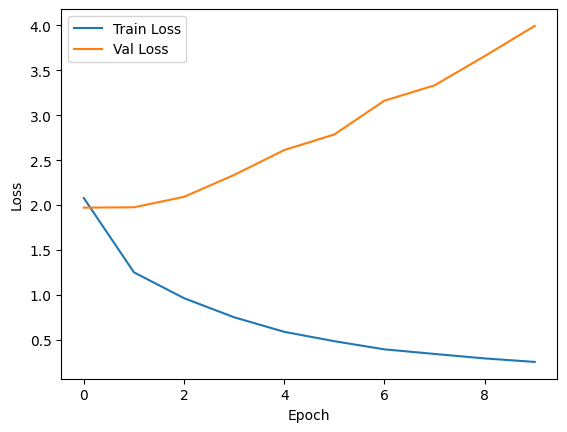

In [33]:
# Plot accuracy
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 3

In [19]:
model_3 = cnn_model_three()
history_3 = model_3.fit(train_X, train_y, 
                    epochs=15, 
                    validation_data=(val_X, val_y), 
                    callbacks=[early_stopping, reduce_lr])

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 628s 602ms/step - accuracy: 0.1120 - loss: 4.4598 - val_accuracy: 0.1040 - val_loss: 2.9969 - learning_rate: 0.0010
Epoch 2/15
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 605s 582ms/step - accuracy: 0.1002 - loss: 2.9433 - val_accuracy: 0.1042 - val_loss: 2.9890 - learning_rate: 0.0010
Epoch 3/15
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 594s 572ms/step - accuracy: 0.1026 - loss: 2.9312 - val_accuracy: 0.1038 - val_loss: 2.9812 - learning_rate: 0.0010
Epoch 4/15
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 596s 575ms/step - accuracy: 0.1029 - loss: 2.9191 - val_accuracy: 0.1038 - val_loss: 2.9728 - learning_rate: 0.0010
Epoch 5/15
 164/1038 ━━━━━━━━━━━━━━━━━━━━ 8:10 561ms/step - accuracy: 0.1010 - loss: 2.9236

KeyboardInterrupt: 

# **What I Learned**

In [59]:
model_1.save('Models/stage_1_cnn_model_1.keras')